# How much did this whole thing actually change things?
#### lets look into the the impact on the SalishSeaCast files in a specific spot in the JdF

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
from sklearn.neighbors import LocalOutlierFactor as LOF

#### first lets decide on a location in the Salish Sea that feels good to dig into

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

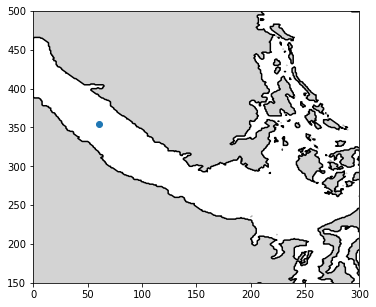

In [3]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.contourf(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([0, 300])
ax.set_ylim([150, 500])
ax.set_aspect(5/7)

ax.scatter(60,355)

In [4]:
#find out how deep this location is and pick the middle
mesh.tmask[0,:,355,60]
#pick z=15

<xarray.DataArray 'tmask' (z: 40)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)
Dimensions without coordinates: z
Attributes:
    standard_name:  tmask
    long_name:      mask for T-grid and W-grid
    flag_values:    0, 1
    flag_meanings:  land, water

#### plot x=60, y=355, z=15 over time in the diff files

In [5]:
dates= [dt.datetime(2019,3,2)+dt.timedelta(days=i) for i in range(int(3))]

In [6]:
# first the original hourly files
path = Path("/results/SalishSea/nowcast-green.201812/")
drop_vars = (
    "nav_lon", "bounds_lon", "nav_lat", "bounds_lat", "area", "depthu_bounds", 
    "time_centered", "time_centered_bounds", "time_counter_bounds",
)

files = [sorted(path.glob("{:%d%b%y}".format(day).lower()+"/SalishSea_1h_*_grid_U.nc")) for day in dates]

mydata = xr.open_mfdataset(files, drop_variables=drop_vars)
u_og = mydata['vozocrtx']

drop_vars = (
    "nav_lon", "bounds_lon", "nav_lat", "bounds_lat", "area", "depthv_bounds", 
    "time_centered", "time_centered_bounds", "time_counter_bounds",
)

files = [sorted(path.glob("{:%d%b%y}".format(day).lower()+"/SalishSea_1h_*_grid_V.nc")) for day in dates]

mydata = xr.open_mfdataset(files, drop_variables=drop_vars)
v_og = mydata['vomecrty']
t_og = mydata['time_counter']

In [7]:
# then the original daily files
path = Path("/results/SalishSea/nowcast-green.201812/")
drop_vars = (
    "nav_lon", "bounds_lon", "nav_lat", "bounds_lat", "area", "depthu_bounds", 
    "time_centered", "time_centered_bounds", "time_counter_bounds",
)

files = [sorted(path.glob("{:%d%b%y}".format(day).lower()+"/SalishSea_1d_*_grid_U.nc")) for day in dates]

mydata = xr.open_mfdataset(files, drop_variables=drop_vars)
u_d = mydata['vozocrtx']

drop_vars = (
    "nav_lon", "bounds_lon", "nav_lat", "bounds_lat", "area", "depthv_bounds", 
    "time_centered", "time_centered_bounds", "time_counter_bounds",
)

files = [sorted(path.glob("{:%d%b%y}".format(day).lower()+"/SalishSea_1d_*_grid_V.nc")) for day in dates]

mydata = xr.open_mfdataset(files, drop_variables=drop_vars)
v_d = mydata['vomecrty']
t_d = mydata['time_counter']

In [8]:
# and then my tideback files
path = Path("/data/rbeutel/analysis/ssc_tidesback/")

files = [sorted(path.glob("U_new_{:%d%b%y}.nc".format(day))) for day in dates]

mydata = xr.open_mfdataset(files, drop_variables=drop_vars)
u_new = mydata['vozocrtx']

files = [sorted(path.glob("V_new_{:%d%b%y}.nc".format(day))) for day in dates]

mydata = xr.open_mfdataset(files, drop_variables=drop_vars)
v_new = mydata['vomecrty']
t_new = mydata['time_counter']

Text(0, 0.5, 'Velocity [m/s]')

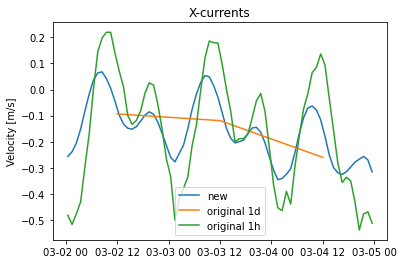

In [9]:
plt.plot(t_new, u_new[:,15,355,60],label='new')
plt.plot(t_d, u_d[:,15,355,60],label='original 1d')
plt.plot(t_og, u_og[:,15,355,60],label='original 1h')
plt.legend()
plt.title('X-currents')
plt.ylabel('Velocity [m/s]')

Text(0, 0.5, 'Velocity [m/s]')

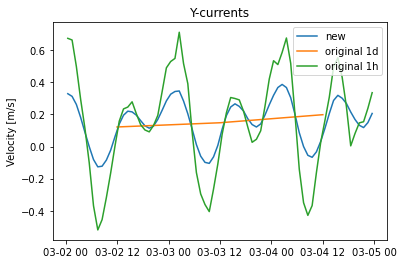

In [10]:
plt.plot(t_new, v_new[:,15,355,60],label='new')
plt.plot(t_d, v_d[:,15,355,60],label='original 1d')
plt.plot(t_og, v_og[:,15,355,60],label='original 1h')
plt.legend()
plt.title('Y-currents')
plt.ylabel('Velocity [m/s]')

In [11]:
diff_u = (abs(u_og[:,15,355,60]/u_new[:,15,355,60])).values
diff_v = (abs(v_og[:,15,355,60]/v_new[:,15,355,60])).values

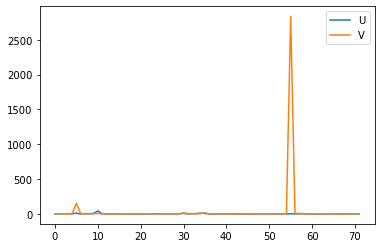

In [12]:
# what is the average difference between the og and the new? - perhaps we can come up with a factor
plt.plot(diff_u, label='U')
plt.plot(diff_v, label='V')
# plt.ylim([-10,10])
plt.legend()

#### woweeeee lots of outliers - lets apply some of the fun stuff we learned in the PRODIGY course (assignment 3 - outlier detection)

In [13]:
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

In [14]:
# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

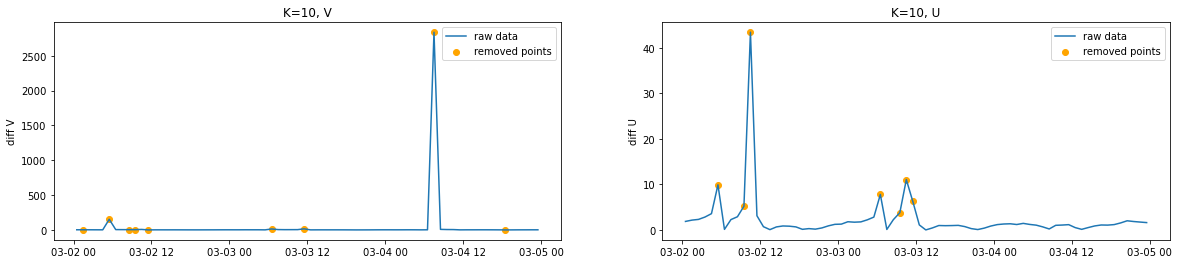

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,4))

ax[0].plot(t_og,diff_v, label='raw data')
ax[0].scatter(time10_v, rem10_v, c='orange',label='removed points')
ax[0].set_title('K=10, V')
ax[0].set_ylabel('diff V')
ax[0].legend()


ax[1].plot(t_og,diff_u, label='raw data')
ax[1].scatter(time10_u, rem10_u, c='orange',label='removed points')
ax[1].set_title('K=10, U')
ax[1].set_ylabel('diff U')
ax[1].legend()

In [16]:
# average factor before outlier removal
print(np.mean(diff_u))
print(np.mean(diff_v))

2.2904610507432546
43.70487160393773


In [17]:
# after outlier removal
print(np.mean(diff_u[lof10_u < 2]))
print(np.mean(diff_v[lof10_v < 2]))

1.1903856879540826
1.8808071767333656


Text(0, 0.5, 'Velocity [m/s]')

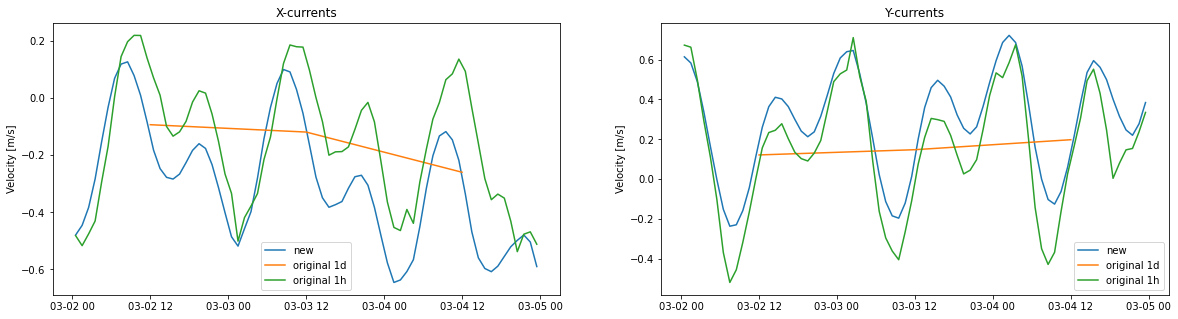

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
fac = 1.87

ax[0].plot(t_new, u_new[:,15,355,60]*fac,label='new')
ax[0].plot(t_d, u_d[:,15,355,60],label='original 1d')
ax[0].plot(t_og, u_og[:,15,355,60],label='original 1h')
ax[0].legend()
ax[0].set_title('X-currents')
ax[0].set_ylabel('Velocity [m/s]')

ax[1].plot(t_new, v_new[:,15,355,60]*fac,label='new')
ax[1].plot(t_d, v_d[:,15,355,60],label='original 1d')
ax[1].plot(t_og, v_og[:,15,355,60],label='original 1h')
ax[1].legend()
ax[1].set_title('Y-currents')
ax[1].set_ylabel('Velocity [m/s]')

#### ok, something around 1.8-1.9 looks preeeeetty good to me, must test with different locations along the JdF and different depths to see if this number is somewhat consistent 

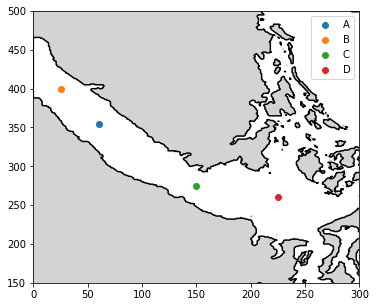

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.contourf(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([0, 300])
ax.set_ylim([150, 500])
ax.set_aspect(5/7)

ax.scatter(60,355,label='A') # 30 cell depth
ax.scatter(25,400,label='B') # 30 cell depth
ax.scatter(150,275,label='C') # 29 cell depth
ax.scatter(225,260,label='D') # 26 cell depth
ax.legend()

### Same depth, different locations

In [20]:
# station A
diff_u = (abs(u_og[:,15,400,25]/u_new[:,15,400,25])).values
diff_v = (abs(v_og[:,15,400,25]/v_new[:,15,400,25])).values

# average factor before outlier removal
print("average U diff = "+str(np.mean(diff_u)))
print("average V diff = "+str(np.mean(diff_v)))

# outlier removal
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

# after outlier removal
print("average U diff, outliers removed= "+str(np.mean(diff_u[lof10_u < 2])))
print("average V diff, outliers removed= "+str(np.mean(diff_v[lof10_v < 2])))

average U diff = 2.213828825613824
average V diff = 2.1549407739033284
average U diff, outliers removed= 2.106616930329594
average V diff, outliers removed= 1.031958879378654


In [21]:
# station C
diff_u = (abs(u_og[:,15,275,150]/u_new[:,15,275,150])).values
diff_v = (abs(v_og[:,15,275,150]/v_new[:,15,275,150])).values

# average factor before outlier removal
print("average U diff = "+str(np.mean(diff_u)))
print("average V diff = "+str(np.mean(diff_v)))

# outlier removal
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

# after outlier removal
print("average U diff, outliers removed= "+str(np.mean(diff_u[lof10_u < 2])))
print("average V diff, outliers removed= "+str(np.mean(diff_v[lof10_v < 2])))

average U diff = 2.9941187597295476
average V diff = 2.697569315954016
average U diff, outliers removed= 2.4243210112401328
average V diff, outliers removed= 2.1258860230617587


In [22]:
# station D
diff_u = (abs(u_og[:,15,260,225]/u_new[:,15,260,225])).values
diff_v = (abs(v_og[:,15,260,225]/v_new[:,15,260,225])).values

# average factor before outlier removal
print("average U diff = "+str(np.mean(diff_u)))
print("average V diff = "+str(np.mean(diff_v)))

# outlier removal
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

# after outlier removal
print("average U diff, outliers removed= "+str(np.mean(diff_u[lof10_u < 2])))
print("average V diff, outliers removed= "+str(np.mean(diff_v[lof10_v < 2])))

average U diff = 1194.0811120749827
average V diff = 10.272143712058217
average U diff, outliers removed= 6.590807629443882
average V diff, outliers removed= 6.344532130115832


### Stations A and D, different depths

In [23]:
# station A - deeper
diff_u = (abs(u_og[:,20,355,60]/u_new[:,20,355,60])).values
diff_v = (abs(v_og[:,20,355,60]/v_new[:,20,355,60])).values

# average factor before outlier removal
print("average U diff = "+str(np.mean(diff_u)))
print("average V diff = "+str(np.mean(diff_v)))

# outlier removal
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

# after outlier removal
print("average U diff, outliers removed= "+str(np.mean(diff_u[lof10_u < 2])))
print("average V diff, outliers removed= "+str(np.mean(diff_v[lof10_v < 2])))

average U diff = 2.975894194455775
average V diff = 2.0386902748510765
average U diff, outliers removed= 1.4424038047672452
average V diff, outliers removed= 1.595489250129735


In [24]:
# station D - deeper
diff_u = (abs(u_og[:,20,260,225]/u_new[:,20,260,225])).values
diff_v = (abs(v_og[:,20,260,225]/v_new[:,20,260,225])).values

# average factor before outlier removal
print("average U diff = "+str(np.mean(diff_u)))
print("average V diff = "+str(np.mean(diff_v)))

# outlier removal
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

# after outlier removal
print("average U diff, outliers removed= "+str(np.mean(diff_u[lof10_u < 2])))
print("average V diff, outliers removed= "+str(np.mean(diff_v[lof10_v < 2])))

average U diff = 16.04957476217185
average V diff = 26.02015700418962
average U diff, outliers removed= 6.718583302090594
average V diff, outliers removed= 5.396761830137926


In [25]:
# station A - shallow
diff_u = (abs(u_og[:,5,355,60]/u_new[:,5,355,60])).values
diff_v = (abs(v_og[:,5,355,60]/v_new[:,5,355,60])).values

# average factor before outlier removal
print("average U diff = "+str(np.mean(diff_u)))
print("average V diff = "+str(np.mean(diff_v)))

# outlier removal
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

# after outlier removal
print("average U diff, outliers removed= "+str(np.mean(diff_u[lof10_u < 2])))
print("average V diff, outliers removed= "+str(np.mean(diff_v[lof10_v < 2])))

average U diff = 6.084692754867028
average V diff = 2.8388532663377117
average U diff, outliers removed= 1.0488450641403058
average V diff, outliers removed= 1.266709537126285


In [26]:
# station D - shallow
diff_u = (abs(u_og[:,5,260,225]/u_new[:,5,260,225])).values
diff_v = (abs(v_og[:,5,260,225]/v_new[:,5,260,225])).values

# average factor before outlier removal
print("average U diff = "+str(np.mean(diff_u)))
print("average V diff = "+str(np.mean(diff_v)))

# outlier removal
d_v = np.array(diff_v).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_v)
lof10_v = abs(clf.negative_outlier_factor_)

d_u = np.array(diff_u).reshape(-1, 1)
clf = LOF(n_neighbors=25)
clf.fit_predict(d_u)
lof10_u = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10_v = d_v[lof10_v > 2]
time10_v = t_og[lof10_v > 2]

rem10_u = d_u[lof10_u > 2]
time10_u = t_og[lof10_u > 2]

# after outlier removal
print("average U diff, outliers removed= "+str(np.mean(diff_u[lof10_u < 2])))
print("average V diff, outliers removed= "+str(np.mean(diff_v[lof10_v < 2])))

average U diff = 29.99839068376462
average V diff = 156.60900616991938
average U diff, outliers removed= 4.581344399550386
average V diff, outliers removed= 1.7159358677433398


## lets calculate the contribution of baroclinic flow

In [27]:
mydata = xr.open_dataset('/ocean/rbeutel/MEOPAR/grid/mesh_mask201702.nc')
e3t = mydata['e3t_0']

In [28]:
# convert e3t to e3u and to e3v
e3t_xshift = e3t.shift(x=-1,fill_value=0)
e3u = e3t_xshift+e3t
e3u = e3u*0.5 #check to make sure this worked
e3u = e3u.rename({'z': 'depthu'})

e3t_yshift = e3t.shift(y=-1,fill_value=0)
e3v = e3t_yshift+e3t
e3v = e3v*0.5
e3v = e3v.rename({'z': 'depthv'})

In [29]:
#calcuate barotropic component
ut = (u_og*e3u[0,:,:,:]).sum(dim='depthu')/e3u[0,:,:,:].sum(dim='depthu')
vt = (v_og*e3v[0,:,:,:]).sum(dim='depthv')/e3v[0,:,:,:].sum(dim='depthv')

In [30]:
#calcuate baroclinic component
uc = u_og-ut
vc = v_og-vt

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


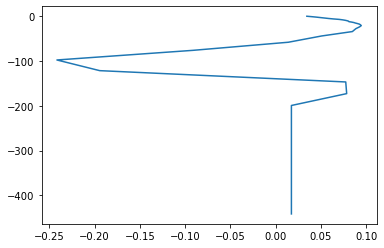

In [36]:
plt.plot(uc[12,:,355,60],-uc.depthu)

In [39]:
XX, YY = np.meshgrid(t_og,-uc.depthu)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


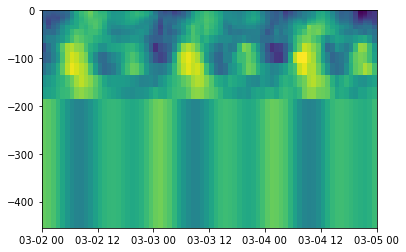

In [41]:
plt.pcolormesh(XX,YY,uc[:,:,355,60].T)

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


KeyboardInterrupt: 

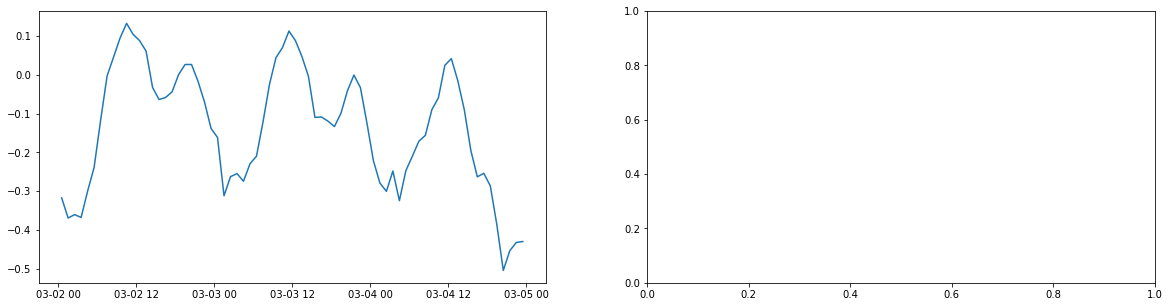

In [31]:
# station A first, all three depths

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
fac = 1.87

ax[0].plot(t_og, uc[:,15,355,60],label='midway')
ax[0].plot(t_og, uc[:,5,355,60],label='shallow')
ax[0].plot(t_og, uc[:,20,355,60],label='deep')
ax[0].legend()
ax[0].set_title('Baroclinic X-currents')
ax[0].set_ylabel('Velocity [m/s]')

ax[1].plot(t_og, vc[:,15,355,60],label='midway')
ax[1].plot(t_og, vc[:,5,355,60],label='shallow')
ax[1].plot(t_og, vc[:,20,355,60],label='deep')
ax[1].legend()
ax[1].set_title('Baroclinic Y-currents')
ax[1].set_ylabel('Velocity [m/s]')

In [ ]:
# station D, all three depths

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
fac = 1.87

ax[0].plot(t_og, uc[:,15,260,225],label='midway')
ax[0].plot(t_og, uc[:,5,260,225],label='shallow')
ax[0].plot(t_og, uc[:,20,260,225],label='deep')
ax[0].legend()
ax[0].set_title('Baroclinic X-currents')
ax[0].set_ylabel('Velocity [m/s]')

ax[1].plot(t_og, vc[:,15,260,225],label='midway')
ax[1].plot(t_og, vc[:,5,260,225],label='shallow')
ax[1].plot(t_og, vc[:,20,260,225],label='deep')
ax[1].legend()
ax[1].set_title('Baroclinic Y-currents')
ax[1].set_ylabel('Velocity [m/s]')